# 统计机器学习第二次作业
### 葡萄酒品种分类——基于Pytorch
王恒 计算数学 220220934161

In [1]:
import torch
import torch.nn as nn
from collections import OrderedDict
import copy
import time
from sklearn import datasets
import matplotlib.pyplot as plt
torch.manual_seed(100)

In [2]:
# 加载数据
data =  datasets.load_wine()

In [3]:
data.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names'])

In [4]:
data['data'].shape

(178, 13)

In [5]:
data['target']

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2])

In [6]:
data['feature_names']

['alcohol',
 'malic_acid',
 'ash',
 'alcalinity_of_ash',
 'magnesium',
 'total_phenols',
 'flavanoids',
 'nonflavanoid_phenols',
 'proanthocyanins',
 'color_intensity',
 'hue',
 'od280/od315_of_diluted_wines',
 'proline']

In [7]:
data_features = torch.tensor(data.data)
data_labels = torch.tensor(data.target)[:,None]

In [8]:
data_features.shape

torch.Size([178, 13])

In [9]:
data_labels.shape

torch.Size([178, 1])

In [10]:
data_set = torch.cat([data_features,data_labels],dim=1)

In [11]:
length = data_set.shape[0]
alpha = 0.6
train_len = int(length*alpha)
test_len = length - train_len
train_data, test_data = torch.utils.data.random_split(data_set,[train_len,test_len])

In [12]:
train_data = torch.tensor([item.numpy() for item in train_data])
test_data = torch.tensor([item.numpy() for item in test_data])

d:\Anaconda\envs\py37\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:233.)
  """Entry point for launching an IPython kernel.


In [13]:
train_data.shape

torch.Size([106, 14])

In [14]:
test_data.shape

torch.Size([72, 14])

## 朴素贝叶斯

In [15]:
# 定义模型
class NaiveBayes(nn.Module):
    def __init__(self, n, full_labels, S, lamb) -> None:
        super(NaiveBayes,self).__init__()
        # 归一化参数
        self.max = None
        self.min = None
        self.n = n # 特征数量
        self.full_labels = full_labels # 所有标签
        self.K = len(full_labels) # 标签数量
        self.lamb = lamb # 贝叶斯估计参数lambda
        self.S = S # 每个特征分划区间数，这里默认都为S
        self.cond_prob = torch.zeros([self.K,self.n,S]) # 条件概率
        self.pre_prob = torch.zeros([self.K]) # 先验概率

    def forward(self, features):
        B,n = features.shape
        assert n == self.n
        post_prob = torch.ones([B,1])*self.pre_prob
        # 归一化
        features = (features - self.min) / (self.max - self.min) * 2 - 1
        delta_x = 2 / (self.S - 2)
        for i in range(B):
            for j in range(self.K):
                for k in range(n):
                    if features[i,k] < -1: post_prob[i,j] *= self.cond_prob[j,k,0]
                    elif features[i,k] >= 1: post_prob[i,j] *= self.cond_prob[j,k,-1]
                    else:
                        for h in range(self.S-2):
                            l = -1 + h * delta_x
                            r = l + delta_x
                            if features[i,k] >= l and features[i,k] < r:
                                post_prob[i,j] *= self.cond_prob[j,k,h+1]
                                break
        return self.full_labels[torch.argmax(post_prob,dim=1)]

    def fit(self, train_data):
        # 计算先验概率
        N,_ = train_data.shape
        self.max = torch.max(train_data[:,:-1],dim=0).values
        self.min = torch.min(train_data[:,:-1],dim=0).values
        train_data[:,:-1] = (train_data[:,:-1] - self.min) / (self.max - self.min) * 2 - 1
        features = train_data[:,:-1] # 特征
        labels = train_data[:,-1:].int() # 标签
        delta_x = 2 / (self.S - 2)
        for i in range(self.K):
            labels_i = labels == self.full_labels[i]
            self.pre_prob[i] = (labels_i.sum() + self.lamb) / (N + self.K*self.lamb)
            for j in range(self.n):
                self.cond_prob[i,j,0] = 1 / self.S
                for k in range(self.S-1):
                    l = -1 + k * delta_x
                    r = l + delta_x
                    features_ij = features[labels_i[:,0],j]
                    features_ijk = features_ij[(features_ij>=l)*(features_ij<r)]
                    self.cond_prob[i,j,k+1] = (features_ijk.shape[0] + self.lamb) / (labels_i.sum() + self.S*self.lamb)
        return self.pre_prob, self.cond_prob

In [16]:
naive_bayse = NaiveBayes(
    n=train_data.shape[1]-1,
    full_labels=torch.tensor([0,1,2]),
    S=10,
    lamb=0.0001
)

In [17]:
# 训练
_,_ = naive_bayse.fit(
    train_data = copy.deepcopy(train_data)
)

In [18]:
# 测试
predicts = naive_bayse(
    copy.deepcopy(test_data[:,:-1])
)

In [19]:
predicts

tensor([2, 0, 0, 0, 2, 2, 1, 2, 0, 0, 1, 0, 2, 2, 2, 1, 1, 2, 0, 0, 0, 0, 0, 2,
        0, 2, 1, 1, 0, 2, 2, 0, 1, 2, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 2, 1, 0, 0,
        0, 0, 1, 1, 0, 1, 0, 1, 2, 1, 2, 0, 1, 2, 2, 1, 1, 0, 1, 2, 0, 1, 0, 2])

In [20]:
test_data[:,-1].int()

tensor([2, 0, 0, 0, 2, 2, 1, 2, 0, 0, 1, 0, 2, 2, 2, 1, 1, 2, 1, 0, 0, 0, 0, 2,
        0, 2, 1, 1, 0, 2, 2, 0, 1, 2, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 2, 1, 0, 0,
        0, 0, 1, 1, 0, 1, 0, 1, 2, 1, 2, 0, 2, 2, 2, 1, 1, 0, 1, 2, 0, 1, 0, 2],
       dtype=torch.int32)

In [21]:
# 打印准确率
print(torch.sum(predicts == test_data[:,-1].int()) / test_data.shape[0])

tensor(0.9583)


## 决策树

In [22]:
# # 定义模型（ID3算法）
# class Node():
#     def __init__(self, father = None, childrens = [], mark = None) -> None:
#         super(Node,self).__init__()
#         self.father = father
#         self.childrens = childrens
#         self.mark = mark
#         self.split = []
    
#     def is_leaf(self):
#         if self.mark is None:
#             return False
#         else:
#             return True

# class DecisionTree(nn.Module):
#     def __init__(self, full_features, full_labels, S, esplison = 0.001) -> None:
#         super(DecisionTree,self).__init__()
#         self.esplison = esplison
#         self.S = S # 特征划分数
#         self.full_features = full_features
#         self.feature_num = len(full_features)
#         self.full_labels = full_labels
#         self.K = len(full_labels)
#         # 归一化参数
#         self.min = None
#         self.max = None
#         self.Tree = Node()

#     def create_tree(self,D,A,node = None,root = None):
#         if node is None: 
#             node = self.Tree
#             root = self.Tree
#             # 归一化
#             self.max = torch.max(D[:,:-1],dim=0).values
#             self.min = torch.min(D[:,:-1],dim=0).values
#             D[:,:-1] = (D[:,:-1] - self.min) / (self.max - self.min) * 2 - 1
#         features = D[:,:-1]
#         labels = D[:,-1:]
#         # 只有一种标签时候直接返回
#         if torch.unique(labels).shape[0] == 1:
#             node.mark = D[0,-1]
#             return root
#         # 标签数量为空时直接返回
#         elif len(A) == 0:
#             count = torch.bincount(labels)
#             mark = torch.argmax(count)
#             node.mark = mark
#             return root
#         else:
#             # 计算各特征的信息增益，选择最大信息增益特征
#             g = self.information_gain(D,A[0])
#             Ag = 0
#             for i in range(len(A) - 1):
#                 gi = self.information_gain(D,A[i+1])
#                 if gi > g:
#                     g = gi
#                     Ag = i+1
#             # 达到精度返回
#             if g < self.esplison:
#                 count = torch.bincount(labels)
#                 mark = torch.argmax(count)
#                 node.mark = mark
#                 return root
#             # 未达到精度继续递归生成子节点
#             else:
#                 l = None
#                 r = -1
#                 delta_x = 2 / (self.S - 2)
#                 feature_i = features[:,Ag]
#                 Ai = copy.deepcopy(A)
#                 Ai[Ag] = False
#                 for i in range(self.S):
#                     if i == self.S - 1: r = None
#                     if l is None:
#                         index = feature_i < r
#                         # 当前数据不空
#                         if index.sum() > 0:
#                             node.split.append(lambda x: x < r) # 用于判别并分划当前特征
#                             Di = D[index,:] # Di一定非空
#                             assert Di.shape[0] > 0
#                             nodei = Node(father=node)
#                             # 递归处理子节点
#                             self.create_tree(Di,Ai,nodei,root)
#                             node.childrens.append(nodei)
#                             l = r
#                             r = r + delta_x
#                     elif r is None:
#                         index = feature_i >= l
#                         # 当前数据不空
#                         if index.sum() > 0:
#                             node.split.append(lambda x: x < r) # 用于判别并分划当前特征
#                             Di = D[index,:] # Di一定非空
#                             assert Di.shape[0] > 0
#                             nodei = Node(father=node)
#                             # 递归处理子节点
#                             self.create_tree(Di,Ai,nodei,root)
#                             node.childrens.append(nodei)
#                             l = r
#                             r = r + delta_x
                        
                            
                

#     # 计算经验熵
#     def empirical_entropy(self,D):
#         labels = data_set[:,-1:]
#         HD = 0
#         for j in range(self.K):
#             labels_j = labels == self.full_labels[j]
#             HD -= labels_j.sum() / D * torch.log2(labels_j.sum() / D)
#         return HD

#     # 计算A对于数据集D的经验条件熵
#     def empirical_cond_entropy(self,D,A):
#         D_ = D.shape[0]
#         index = self.full_features == A
#         features = D[:,:-1]
#         labels = D[:,-1:]
#         DA = features[:,index]
#         DAi = DA[DA < -1,None]
#         Li = labels[DA < -1,:]
#         HDA = len(DAi) / D_ * self.empirical_entropy(torch.cat([DAi,Li],dim=1))
#         DAi = DA[DA >= 1,None]
#         Li = labels[DA >= 1,:]
#         HDA += len(DAi) / D_ * self.empirical_entropy(torch.cat([DAi,Li],dim=1))
#         delta_x = 2 / (self.S - 2)
#         for i in range(self.S - 2):
#             l = -1 + i * delta_x
#             r = l + delta_x
#             index_i = (DA >= l) * (DA < r)
#             DAi = DA[index_i,None]
#             Li = labels[index_i,:]
#             HDA += len(DAi) / D_ * self.empirical_entropy(torch.cat([DAi,Li],dim=1))
#         return HDA

#     # 计算信息增益
#     def information_gain(self,data_set,feature):
#         if self.min is None or self.max is None:
#             self.max = torch.max(train_data[:,:-1],dim=0).values
#             self.min = torch.min(train_data[:,:-1],dim=0).values
#         # 特征归一化到[-1,1]
#         train_data[:,:-1] = (train_data[:,:-1] - self.min) / (self.max - self.min) * 2 - 1

#         index = self.full_features == feature
#         D,_ = data_set
#         assert torch.sum(index) == 1 and D > 1
#         # 计算经验熵
#         HD = self.empirical_entropy(data_set)
#         # 计算feature对于数据集data_set的经验条件熵
#         HDA = self.empirical_cond_entropy(data_set,feature)
#         return HD - HDA


## logistic 回归

In [23]:
class Logistic(nn.Module):
    def __init__(self,feature_num,class_num) -> None:
        super(Logistic,self).__init__()
        self.feature_num = feature_num
        self.class_num = class_num
        self.linear = nn.Sequential(
            nn.BatchNorm1d(feature_num),
            nn.Linear(feature_num,class_num-1,bias=False)
        )

    def forward(self, x):
        B,d = x.shape
        assert d == self.feature_num and B > 0
        y = torch.cat([torch.exp(self.linear(x)),torch.ones([B,1])],dim=1)
        y = y / torch.sum(y,dim=1,keepdim=True)
        return y
    
# 负对数似然损失函数
class NLLLoss(nn.Module):
    def __init__(self) -> None:
        super().__init__()
    
    def forward(self,y_pre,y_rel):
        assert y_pre.shape == y_rel.shape
        loss = -torch.log(y_pre)*y_rel
        return torch.sum(loss)

def train(model, data_set, batch_size, epoch = 1000, learning_rate = 1e-3):
    N,_ = data_set.shape
    criterion = NLLLoss()
    optim = torch.optim.SGD(model.parameters(),learning_rate,momentum=0) # 动量设置为0
    
    start = time.time()
    loss_values = torch.zeros(epoch)
    for i in range(epoch):
        model.train()
        optim.zero_grad()
        index = torch.randint(0,N,[batch_size]) # 随机选取batch条数据
        data_i = data_set[index,:]
        x_i = data_i[:,:-1].to(torch.float32)
        y_i = nn.functional.one_hot(data_i[:,-1].to(torch.int64),num_classes=model.class_num)
        outputs = model(x_i)
        loss = criterion(outputs,y_i)
        loss.backward()
        optim.step()

        model.eval()
        loss_values[i] = loss.item()

        print('\r%5d/{}|{}{}|{:.2f}s  [Loss: %e]'.format(
            epoch,
            "#"*int((i+1)/epoch*50),
            " "*(50-int((i+1)/epoch*50)),
            time.time() - start) %
            (i+1,
            loss_values[i]), end = ' ', flush=True)
    print("\nTraining has been completed.")
    return loss_values

In [24]:
model = Logistic(
    feature_num=train_data.shape[1]-1,
    class_num=3
)

In [25]:
loss_values = train(
    model=model,
    data_set=train_data,
    batch_size=20,
    epoch=2000,
    learning_rate=1e-3
)

    6/2000|                                                  |0.33s  [Loss: 1.793066e+01] 

 2000/2000|##################################################|7.28s  [Loss: 1.496643e+00]                                 
Training has been completed.


In [26]:
predicts = model(
    test_data[:,:-1].float()
)

In [27]:
predicts = torch.argmax(predicts,dim=1)

In [28]:
predicts

tensor([2, 0, 0, 0, 2, 2, 1, 2, 0, 0, 1, 0, 2, 2, 2, 1, 1, 2, 1, 0, 0, 0, 0, 2,
        0, 2, 1, 1, 0, 2, 2, 0, 1, 2, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 2, 1, 0, 0,
        0, 0, 1, 1, 0, 1, 0, 1, 2, 1, 2, 0, 2, 2, 2, 2, 1, 0, 1, 2, 0, 1, 0, 2])

In [29]:
test_data[:,-1].int()

tensor([2, 0, 0, 0, 2, 2, 1, 2, 0, 0, 1, 0, 2, 2, 2, 1, 1, 2, 1, 0, 0, 0, 0, 2,
        0, 2, 1, 1, 0, 2, 2, 0, 1, 2, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 2, 1, 0, 0,
        0, 0, 1, 1, 0, 1, 0, 1, 2, 1, 2, 0, 2, 2, 2, 1, 1, 0, 1, 2, 0, 1, 0, 2],
       dtype=torch.int32)

In [30]:
# 打印准确率
print(torch.sum(predicts == test_data[:,-1].int()) / test_data.shape[0])

tensor(0.9722)


## 支持向量机

### 线性

In [31]:
# 定义模型
class SVMLinear(nn.Module):
    def __init__(self,feature_num) -> None:
        super(SVMLinear,self).__init__()
        self.feature_num = feature_num
        self.batch_norm = nn.BatchNorm1d(feature_num) # 特征批量归一化，学习归一化参数
        self.linear = nn.Linear(feature_num,1)
    
    def forward(self, x, signed = True):
        B,d = x.shape
        assert B > 0 and d == self.feature_num
        normed = self.batch_norm(x)
        outputs = self.linear(normed)
        if signed:
            return torch.sign(outputs)
        else:
            return outputs

# 合页损失函数
class HingeLoss(nn.Module):
    def __init__(self,lamb) -> None:
        super(HingeLoss,self).__init__()
        self.lamb = lamb

    def forward(self,res_pre_linear_values,res_rel,parameters):
        return torch.sum(torch.relu(1 - res_rel*res_pre_linear_values)) + self.lamb*torch.norm(parameters)**2
    
def train_svm(model, data_set, batch_size, lamb=1, epoch = 1000, learning_rate = 1e-3):
    N,_ = data_set.shape
    criterion = HingeLoss(lamb)
    optim = torch.optim.SGD(model.parameters(),learning_rate,momentum=0) # 动量设置为0
    
    start = time.time()
    loss_values = torch.zeros(epoch)
    for i in range(epoch):
        model.train()
        optim.zero_grad()
        index = torch.randint(0,N,[batch_size]) # 随机选取batch条数据
        data_i = data_set[index,:]
        x_i = data_i[:,:-1].to(torch.float32)
        y_i = data_i[:,-1:].to(torch.int32)
        outputs = model(x_i,signed=False)
        loss = criterion(outputs,y_i,model.linear.weight)
        loss.backward()
        optim.step()

        model.eval()
        loss_values[i] = loss.item()

        print('\r%5d/{}|{}{}|{:.2f}s  [Loss: %e]'.format(
            epoch,
            "#"*int((i+1)/epoch*50),
            " "*(50-int((i+1)/epoch*50)),
            time.time() - start) %
            (i+1,
            loss_values[i]), end = ' ', flush=True)
    print("\nTraining has been completed.")
    return loss_values

In [32]:
svm1 = SVMLinear(
    feature_num=train_data.shape[1]-1
)
svm2 = SVMLinear(
    feature_num=train_data.shape[1]-1
)

In [33]:
train_data_svm1 = copy.deepcopy(train_data)
train_data_svm2 = copy.deepcopy(train_data)
train_data_svm1[train_data_svm1[:,-1].int() > 0,-1] = -1
train_data_svm1[train_data_svm1[:,-1].int() == 0,-1] = 1
train_data_svm2 = train_data_svm2[train_data_svm2[:,-1].int() > 0,:]
train_data_svm2[train_data_svm2[:,-1].int() == 2,-1] = -1

In [34]:
train_data_svm1.shape

torch.Size([106, 14])

In [35]:
train_data_svm2.shape

torch.Size([76, 14])

In [36]:
train_data_svm1[:,-1]

tensor([-1., -1.,  1., -1., -1., -1.,  1., -1., -1., -1., -1., -1.,  1., -1.,
         1., -1., -1., -1.,  1., -1.,  1., -1., -1., -1., -1.,  1.,  1., -1.,
         1.,  1., -1., -1., -1., -1.,  1., -1., -1.,  1., -1.,  1., -1., -1.,
        -1., -1., -1., -1., -1., -1.,  1.,  1., -1.,  1., -1.,  1., -1., -1.,
        -1.,  1., -1., -1., -1.,  1., -1., -1., -1.,  1., -1., -1., -1.,  1.,
        -1., -1., -1.,  1.,  1.,  1., -1., -1.,  1.,  1., -1.,  1., -1., -1.,
        -1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  1., -1.,
        -1., -1., -1.,  1., -1., -1., -1., -1.], dtype=torch.float64)

In [37]:
train_data_svm2[:,-1]

tensor([-1., -1., -1.,  1., -1.,  1., -1.,  1., -1.,  1.,  1., -1.,  1.,  1.,
        -1.,  1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1.,  1.,
         1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1., -1.,
         1.,  1., -1.,  1., -1., -1.,  1.,  1., -1.,  1.,  1., -1., -1.,  1.,
         1.,  1.,  1., -1., -1.,  1.,  1.,  1.,  1., -1.,  1., -1., -1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.], dtype=torch.float64)

In [38]:
loss_values = train_svm(
    model=svm1,
    data_set=train_data_svm1,
    batch_size=20,
    lamb=0.1,
    epoch=2000,
    learning_rate=1e-3
)

  166/2000|####                                              |0.48s  [Loss: 1.122805e+00] 

 2000/2000|##################################################|4.70s  [Loss: 2.529774e-01]                   
Training has been completed.


In [39]:
loss_values = train_svm(
    model=svm2,
    data_set=train_data_svm2,
    batch_size=20,
    lamb=0.1,
    epoch=2000,
    learning_rate=1e-3
)

 2000/2000|##################################################|4.82s  [Loss: 2.434435e-01]                 
Training has been completed.


In [40]:
pre_svm1 = svm1(
    test_data[:,:-1].to(torch.float32)
)

In [41]:
pre_svm2 = svm2(
    test_data[pre_svm1[:,0] < 0,:-1].to(torch.float32)
)

In [42]:
predicts = pre_svm1[:,0]
k = 0
for i in range(predicts.shape[0]):
    if predicts[i] > 0: predicts[i] = 0
    elif predicts[i] < 0 and pre_svm2[k,0] > 0:
        predicts[i] = 1
        k += 1
    else:
        predicts[i] = 2
        k += 1

In [43]:
predicts.int()

tensor([2, 0, 0, 0, 2, 2, 1, 2, 0, 0, 1, 0, 2, 2, 2, 1, 1, 2, 0, 0, 0, 0, 0, 2,
        0, 2, 1, 1, 0, 2, 2, 0, 1, 2, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 2, 1, 0, 0,
        0, 0, 1, 1, 0, 1, 0, 1, 2, 2, 2, 0, 2, 2, 2, 2, 1, 0, 1, 2, 0, 1, 0, 2],
       dtype=torch.int32)

In [44]:
test_data[:,-1].int()

tensor([2, 0, 0, 0, 2, 2, 1, 2, 0, 0, 1, 0, 2, 2, 2, 1, 1, 2, 1, 0, 0, 0, 0, 2,
        0, 2, 1, 1, 0, 2, 2, 0, 1, 2, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 2, 1, 0, 0,
        0, 0, 1, 1, 0, 1, 0, 1, 2, 1, 2, 0, 2, 2, 2, 1, 1, 0, 1, 2, 0, 1, 0, 2],
       dtype=torch.int32)

In [45]:
# 打印准确率
print(torch.sum(predicts == test_data[:,-1].int()) / test_data.shape[0])

tensor(0.9444)


### 非线性

In [46]:
# 观察数据分布
train_data_nonlinear = copy.deepcopy(train_data)
max = torch.max(train_data_nonlinear[:,:-1],dim=0).values
min = torch.min(train_data_nonlinear[:,:-1],dim=0).values
train_data_nonlinear[:,:-1] = (train_data_nonlinear[:,:-1] - min) / (max - min) * 2 - 1

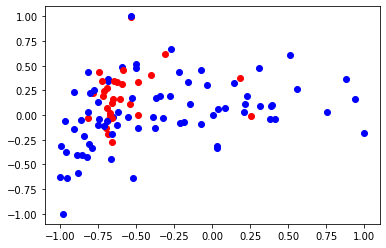

In [47]:
k1 = 1
k2 = 2
for i in range(train_data_nonlinear.shape[0]):
    if train_data_nonlinear[i,-1].int() == 0:
        plt.scatter(train_data_nonlinear[i,k1],train_data_nonlinear[i,k2],color='r')
    else:
        plt.scatter(train_data_nonlinear[i,k1],train_data_nonlinear[i,k2],color='b')

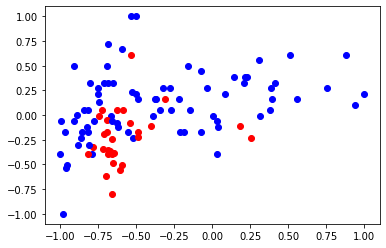

In [48]:
k1 = 1
k2 = 3
for i in range(train_data_nonlinear.shape[0]):
    if train_data_nonlinear[i,-1].int() == 0:
        plt.scatter(train_data_nonlinear[i,k1],train_data_nonlinear[i,k2],color='r')
    else:
        plt.scatter(train_data_nonlinear[i,k1],train_data_nonlinear[i,k2],color='b')

In [49]:
# 高斯核非线性SVM
class SVMNonLinear(nn.Module):
    def __init__(self,feature_num,kernel_data) -> None:
        super(SVMNonLinear,self).__init__()
        self.feature_num = feature_num
        self.kernel_features = kernel_data[:,:-1].to(torch.float32)
        self.kernel_labels = kernel_data[:,-1].to(torch.int32)
        self.batch_norm = nn.BatchNorm1d(feature_num)
        self.linear = nn.Linear(feature_num+kernel_data.shape[0],1)
        self.kernel_params = nn.Parameter(torch.rand(1)+5,requires_grad=True) # 核函数标准差
    
    def forward(self, x, signed = True):
        B,d = x.shape
        assert B > 0 and d == self.feature_num
        # 归一化特征
        normed_data = self.batch_norm(x)
        normed_kernel_data = self.batch_norm(self.kernel_features)
        kernel_features = torch.exp(-torch.mm(normed_data,normed_kernel_data.T) / self.kernel_params**2) * self.kernel_labels
        outputs = self.linear(torch.cat([normed_data,kernel_features],dim=1)) # 核方法特征和原特征结合
        if signed:
            return torch.sign(outputs)
        else:
            return outputs
        

In [50]:
kernel_data_size = 20
kernel_data_svm1 = copy.deepcopy(train_data)[:kernel_data_size]
kernel_data_svm2 = copy.deepcopy(train_data)
kernel_data_svm1[kernel_data_svm1[:,-1].int() > 0,-1] = -1
kernel_data_svm1[kernel_data_svm1[:,-1].int() == 0,-1] = 1
kernel_data_svm2 = kernel_data_svm2[kernel_data_svm2[:,-1].int() > 0,:][:kernel_data_size]
kernel_data_svm2[kernel_data_svm2[:,-1].int() == 2,-1] = -1

In [51]:
kernel_data_svm1.shape

torch.Size([20, 14])

In [52]:
kernel_data_svm2.shape

torch.Size([20, 14])

In [53]:
kernel_data_svm1[:,-1]

tensor([-1., -1.,  1., -1., -1., -1.,  1., -1., -1., -1., -1., -1.,  1., -1.,
         1., -1., -1., -1.,  1., -1.], dtype=torch.float64)

In [54]:
kernel_data_svm2[:,-1]

tensor([-1., -1., -1.,  1., -1.,  1., -1.,  1., -1.,  1.,  1., -1.,  1.,  1.,
        -1.,  1., -1., -1.,  1.,  1.], dtype=torch.float64)

In [55]:
svm1 = SVMNonLinear(
    feature_num=train_data.shape[1]-1,
    kernel_data=kernel_data_svm1
)
svm2 = SVMNonLinear(
    feature_num=train_data.shape[1]-1,
    kernel_data=kernel_data_svm2
)

In [56]:
train_data_svm1 = copy.deepcopy(train_data)
train_data_svm2 = copy.deepcopy(train_data)
train_data_svm1[train_data_svm1[:,-1].int() > 0,-1] = -1
train_data_svm1[train_data_svm1[:,-1].int() == 0,-1] = 1
train_data_svm2 = train_data_svm2[train_data_svm2[:,-1].int() > 0,:]
train_data_svm2[train_data_svm2[:,-1].int() == 2,-1] = -1

In [57]:
loss_values = train_svm(
    model=svm1,
    data_set=train_data_svm1,
    batch_size=20,
    lamb=0.1,
    epoch=2000,
    learning_rate=1e-3
)

 2000/2000|##################################################|6.18s  [Loss: 2.596327e-01]                         
Training has been completed.


In [58]:
loss_values = train_svm(
    model=svm2,
    data_set=train_data_svm2,
    batch_size=20,
    lamb=0.1,
    epoch=2000,
    learning_rate=1e-3
)

 2000/2000|##################################################|6.72s  [Loss: 2.472040e-01]                                  
Training has been completed.


In [59]:
pre_svm1 = svm1(
    test_data[:,:-1].to(torch.float32)
)

In [60]:
pre_svm2 = svm2(
    test_data[pre_svm1[:,0] < 0,:-1].to(torch.float32)
)

In [61]:
predicts = pre_svm1[:,0]
k = 0
for i in range(predicts.shape[0]):
    if predicts[i] > 0: predicts[i] = 0
    elif predicts[i] < 0 and pre_svm2[k,0] > 0:
        predicts[i] = 1
        k += 1
    else:
        predicts[i] = 2
        k += 1

In [62]:
predicts.int()

tensor([2, 0, 0, 0, 2, 2, 1, 2, 0, 0, 1, 0, 2, 2, 2, 1, 1, 2, 0, 0, 0, 0, 0, 2,
        0, 2, 1, 1, 0, 2, 2, 0, 1, 2, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 2, 1, 0, 0,
        0, 0, 1, 1, 0, 1, 0, 1, 2, 1, 2, 0, 2, 2, 2, 2, 1, 0, 1, 2, 0, 1, 0, 2],
       dtype=torch.int32)

In [63]:
test_data[:,-1].int()

tensor([2, 0, 0, 0, 2, 2, 1, 2, 0, 0, 1, 0, 2, 2, 2, 1, 1, 2, 1, 0, 0, 0, 0, 2,
        0, 2, 1, 1, 0, 2, 2, 0, 1, 2, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 2, 1, 0, 0,
        0, 0, 1, 1, 0, 1, 0, 1, 2, 1, 2, 0, 2, 2, 2, 1, 1, 0, 1, 2, 0, 1, 0, 2],
       dtype=torch.int32)

In [64]:
# 打印准确率
print(torch.sum(predicts == test_data[:,-1].int()) / test_data.shape[0])

tensor(0.9583)


## 多层非线性感知机（神经网络）

In [65]:
class MLP(nn.Module):
    def __init__(self,feature_num,class_num,hidden_dim=20,layer_num=2) -> None:
        super(MLP,self).__init__()
        self.feature_num = feature_num
        self.class_num = class_num
        self.hidden_dim = hidden_dim
        self.layer_num = layer_num
        self.model = nn.Sequential(
            OrderedDict(
                [("input_layer",
                    nn.Sequential(
                        nn.BatchNorm1d(feature_num),
                        nn.Linear(feature_num,hidden_dim),
                        nn.Tanh()
                    ))] + 
                [("hidden_layer_"+str(i+1),
                    nn.Sequential(
                        nn.Linear(hidden_dim,hidden_dim),
                        nn.Tanh()
                    )) for i in range(layer_num-1)] + 
                [("output_layer",
                    nn.Sequential(
                        nn.Linear(hidden_dim,class_num),
                        nn.Softmax(dim=1)
                    ))]
            )
        )
    def forward(self,x):
        return self.model(x)

In [66]:
mlp = MLP(
    feature_num=train_data.shape[1]-1,
    class_num=3,
    hidden_dim=30,
    layer_num=2
)

In [67]:
loss_values = train(
    model=mlp,
    data_set=train_data,
    batch_size=20,
    epoch=2000,
    learning_rate=1e-3
)

 2000/2000|##################################################|5.84s  [Loss: 1.520115e+00]                             
Training has been completed.


In [68]:
predicts = mlp(
    test_data[:,:-1].float()
)

In [69]:
predicts = torch.argmax(predicts,dim=1)

In [70]:
predicts

tensor([2, 0, 0, 0, 2, 2, 1, 2, 0, 0, 1, 0, 2, 2, 2, 1, 1, 2, 1, 0, 0, 0, 0, 2,
        0, 2, 1, 1, 0, 2, 2, 0, 1, 2, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 2, 1, 0, 0,
        0, 0, 1, 1, 0, 1, 0, 1, 2, 1, 2, 0, 2, 2, 2, 2, 1, 0, 1, 2, 0, 1, 0, 2])

In [71]:
test_data[:,-1].int()

tensor([2, 0, 0, 0, 2, 2, 1, 2, 0, 0, 1, 0, 2, 2, 2, 1, 1, 2, 1, 0, 0, 0, 0, 2,
        0, 2, 1, 1, 0, 2, 2, 0, 1, 2, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 2, 1, 0, 0,
        0, 0, 1, 1, 0, 1, 0, 1, 2, 1, 2, 0, 2, 2, 2, 1, 1, 0, 1, 2, 0, 1, 0, 2],
       dtype=torch.int32)

In [72]:
# 打印准确率
print(torch.sum(predicts == test_data[:,-1].int()) / test_data.shape[0])

tensor(0.9722)
